In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from src.utils.paths import COMPARISONS_DIR
from sklearn.metrics import (
    precision_recall_curve, 
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay
)

### PERFORMANCE HEATMAP

In [15]:
def plot_performance_heatmap(model_name, save_path=None):
    """
    Heatmap showing all metrics for all methods.
    """
    # Load results CSV
    results_path = COMPARISONS_DIR / "tables" / "all_methods_combined.csv"
    results = pd.read_csv(results_path)
    
    # Filter to one model (e.g., Random Forest)
    model_results = results[results['model'] == model_name]
    
    # Pivot: methods as rows, metrics as columns
    pivot = model_results.pivot_table(
        index='method',
        values=['accuracy', 'precision', 'recall', 'f1_score', 'auc'],
        aggfunc='max'
    )
    
    # Plot
    plt.figure(figsize=(10, 12))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn',
               vmin=0.7, vmax=1.0, cbar_kws={'label': 'Score'})

    title = f"Performance Metrics Heatmap - {model_name}"
    plt.title(title, 
             fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Metric', fontsize=14, fontweight='bold')
    plt.ylabel('Feature Selection Method', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

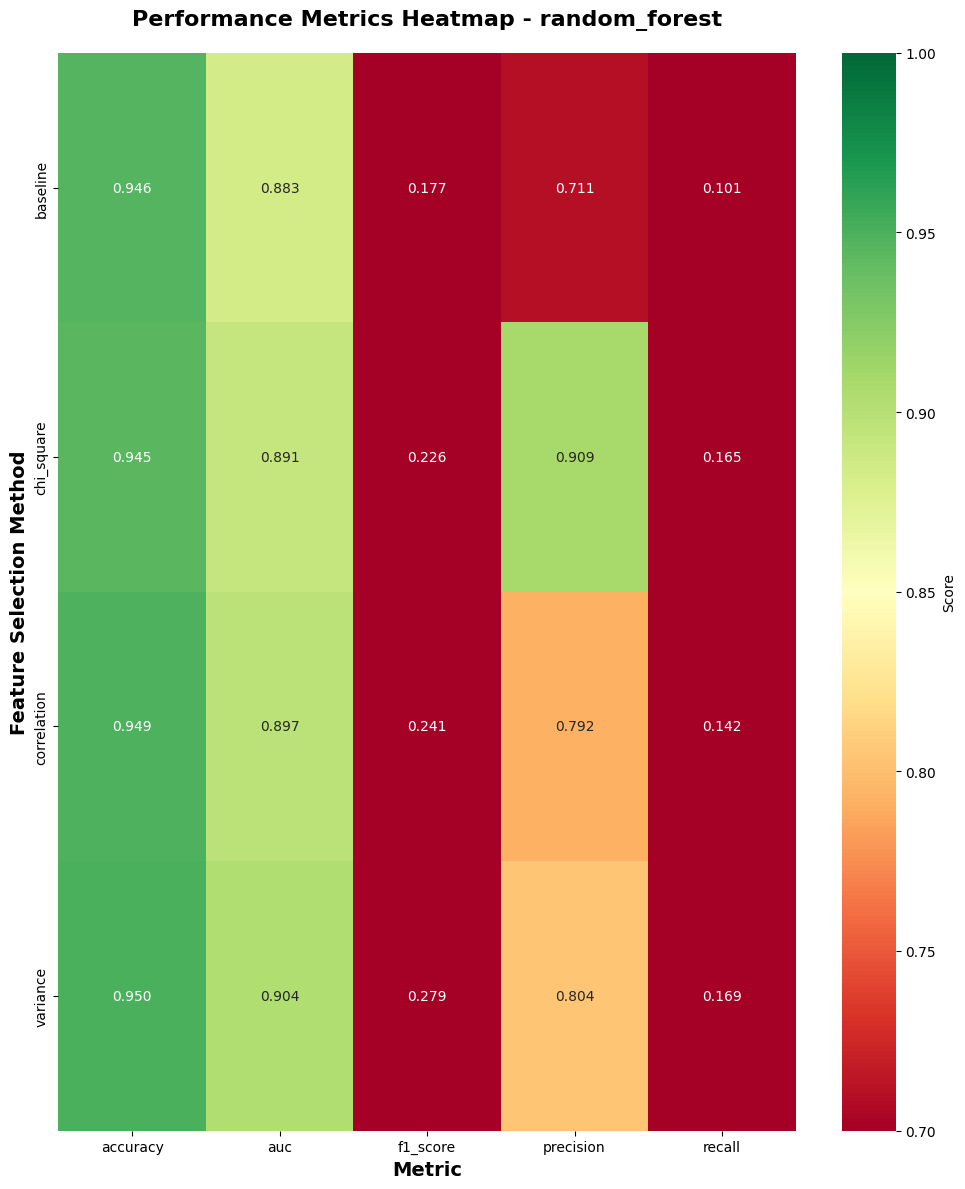

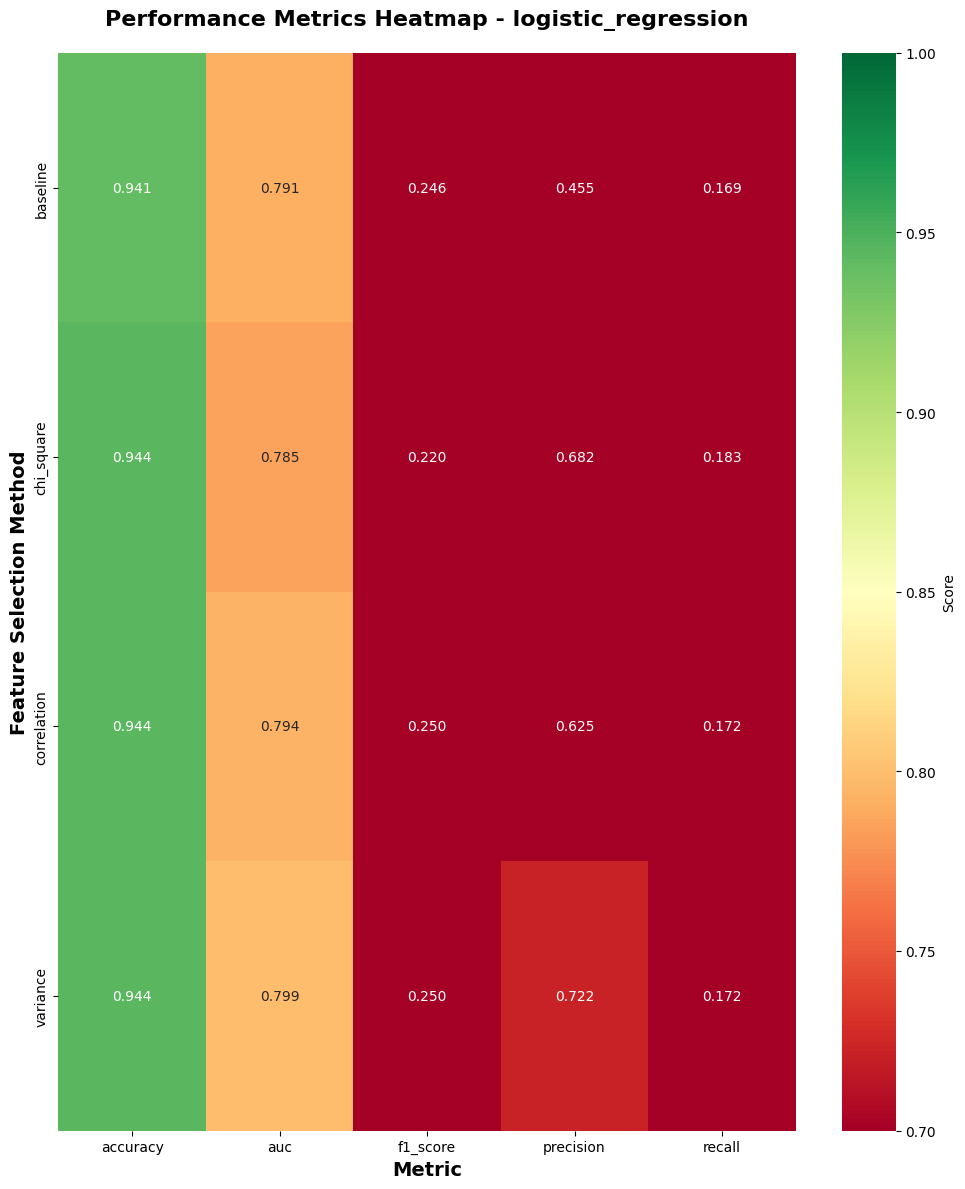

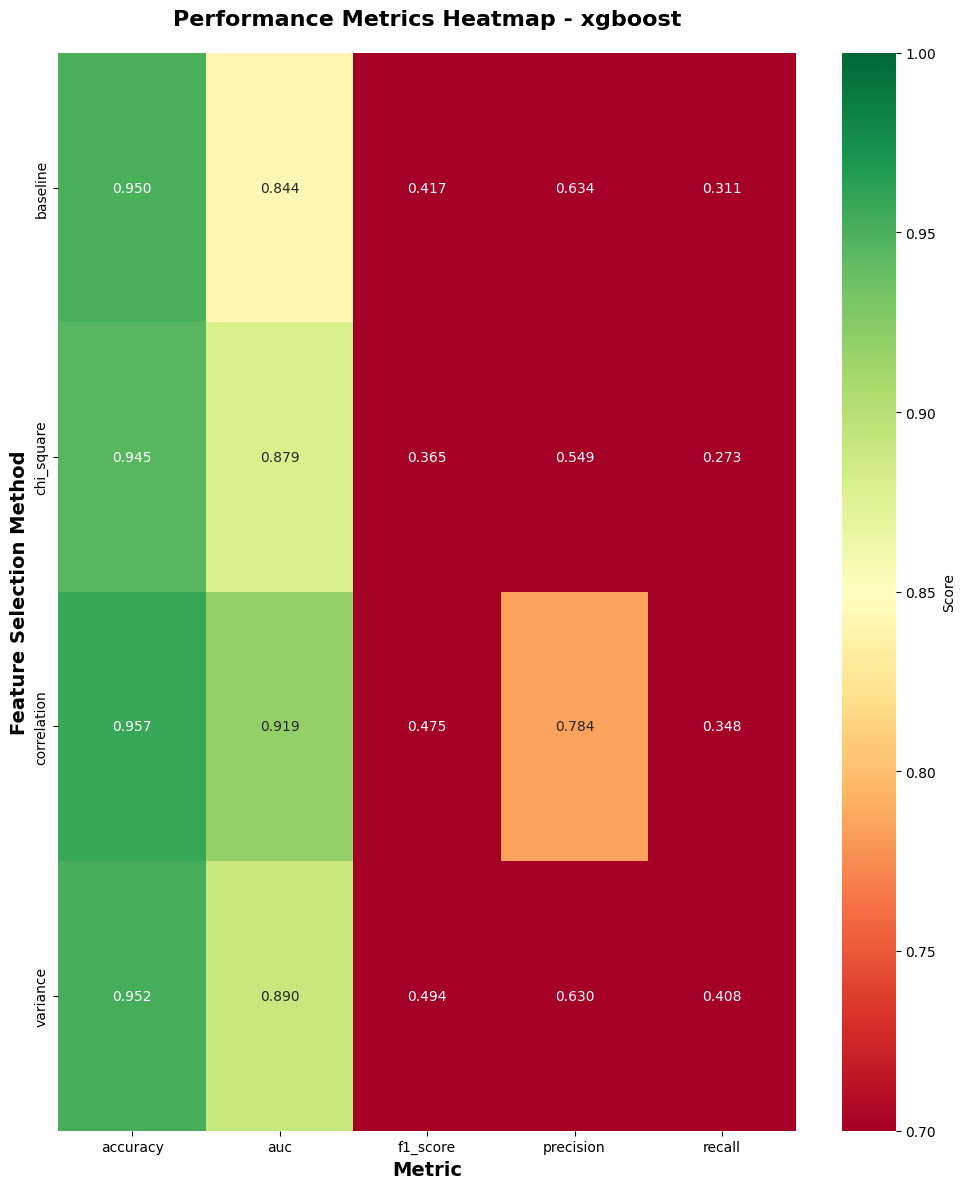

In [16]:
models = ['random_forest', 'logistic_regression', 'xgboost']
for model_name in models:
    path_value = COMPARISONS_DIR / "plots" / f"performance_heatmap_{model_name}.png"
    save_path = Path(path_value)
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plot_performance_heatmap(model_name, save_path)

### PR-AUC SCORES COMPARISON (Bar Chart)

In [17]:
def plot_pr_auc_comparison(methods, dataset, models, save_path=None):
    """
    Compare PR-AUC scores across methods and models.
    """
    pr_aucs = []
    
    for method in methods:
        for model in models:
            preds = load_predictions(method, dataset, model)
            precision, recall, _ = precision_recall_curve(
                preds['y_true'], 
                preds['y_pred_proba']
            )
            pr_auc = auc(recall, precision)
            
            pr_aucs.append({
                'method': method,
                'model': model,
                'pr_auc': pr_auc
            })
    
    df = pd.DataFrame(pr_aucs)
    
    # Plot grouped bar chart
    pivot = df.pivot(index='method', columns='model', values='pr_auc')
    
    ax = pivot.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.xlabel('Feature Selection Method', fontsize=14, fontweight='bold')
    plt.ylabel('PR-AUC Score', fontsize=14, fontweight='bold')
    plt.title('PR-AUC Comparison Across Methods and Models', 
             fontsize=16, fontweight='bold', pad=20)
    plt.legend(title='Model', loc='best')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [19]:
methods = ['baseline', 'correlation']
models = ['logistic_regression', 'random_forest', 'xgboost']
dataset = 'ibtracs.last3years'
save_path = COMPARISONS_DIR / "plots" / "pr_auc_comparison.png"
plot_pr_auc_comparison(methods, dataset, models, save_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/anitarazafi/Desktop/masters/code/feature-selection/results/comparisons/predictions/l1_lasso/ibtracs.last3years/logistic_regression_predictions.json'

In [3]:
# ============================================================
# 1. LOAD PREDICTIONS
# ============================================================

def load_predictions(method, dataset, model):
    """
    Load saved predictions.
    """
    pred_file = COMPARISONS_DIR / "predictions" / f"{method}/{dataset}/{model}_predictions.json"
    with open(pred_file, 'r') as f:
        data = json.load(f)
    return {
        'y_true': np.array(data['y_true']),
        'y_pred': np.array(data['y_pred']),
        'y_pred_proba': np.array(data['y_pred_proba'])
    }

### PR-AUC CURVE

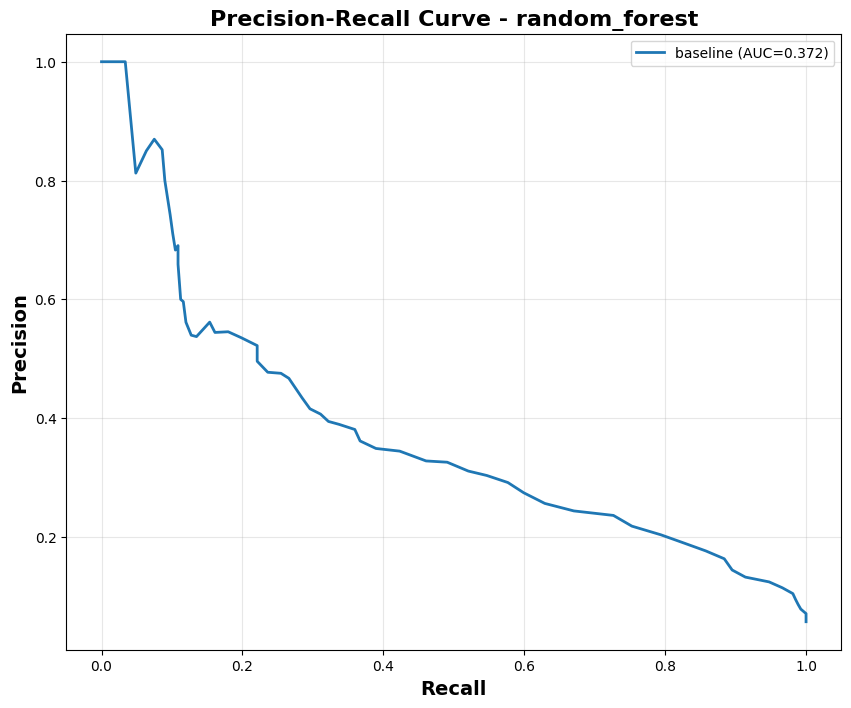

In [4]:
def plot_pr_curve(methods, dataset, model, save_path=None):
    """
    Plot Precision-Recall curve comparing different methods.
    """
    plt.figure(figsize=(10, 8))
    
    for method in methods:
        preds = load_predictions(method, dataset, model)
        
        # Calculate PR curve
        precision, recall, _ = precision_recall_curve(
            preds['y_true'], 
            preds['y_pred_proba']
        )
        pr_auc = auc(recall, precision)
        
        # Plot
        plt.plot(recall, precision, linewidth=2, 
                label=f'{method} (AUC={pr_auc:.3f})')
    
    plt.xlabel('Recall', fontsize=14, fontweight='bold')
    plt.ylabel('Precision', fontsize=14, fontweight='bold')
    plt.title(f'Precision-Recall Curve - {model}', 
             fontsize=16, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
dataset = 'ibtracs.last3years'
# methods = ['baseline', 'correlation', 'variance', 'chi_square', 'l1_lasso', 'l2_ridge', 'shap', 'lime', 'pso', 'de' ]
methods = ['baseline']
models = ['random_forest', 'logistic_regression', 'xgboost']
for model_name in models:
    save_path = Path(COMPARISONS_DIR / "plots" / f"pr_curve_{model_name}.png")
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plot_pr_curve(methods, dataset, model_name, save_path)

### CONFUSION MATRIX HEATMAP

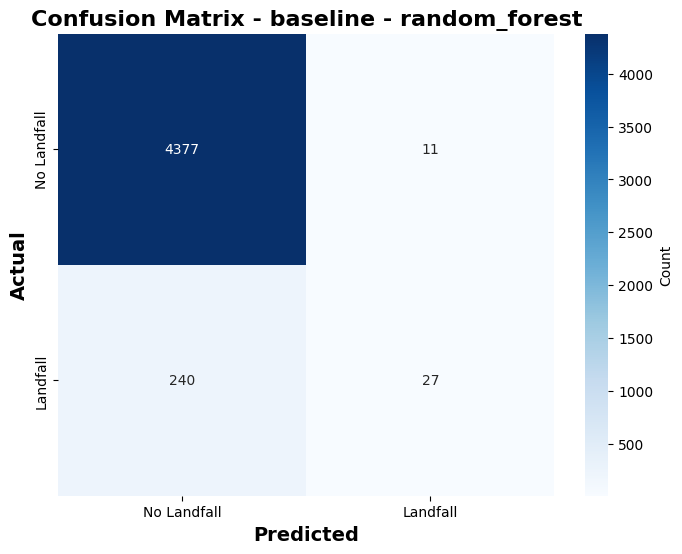

In [7]:
# ============================================================
# 3. CONFUSION MATRIX HEATMAP
# ============================================================

def plot_confusion_matrix(method, dataset, model, save_path=None):
    """
    Plot confusion matrix heatmap.
    """
    preds = load_predictions(method, dataset, model)
    
    # Calculate confusion matrix
    cm = confusion_matrix(preds['y_true'], preds['y_pred'])
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Landfall', 'Landfall'],
                yticklabels=['No Landfall', 'Landfall'],
                cbar_kws={'label': 'Count'})
    
    plt.xlabel('Predicted', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=14, fontweight='bold')
    plt.title(f'Confusion Matrix - {method} - {model}', 
             fontsize=16, fontweight='bold')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

method = 'baseline'
dataset = 'ibtracs.last3years'
model = 'random_forest'
save_path = Path(COMPARISONS_DIR / "plots" / "cm_baseline_rf.png")
save_path.parent.mkdir(parents=True, exist_ok=True)
plot_confusion_matrix(method, dataset, model, save_path)

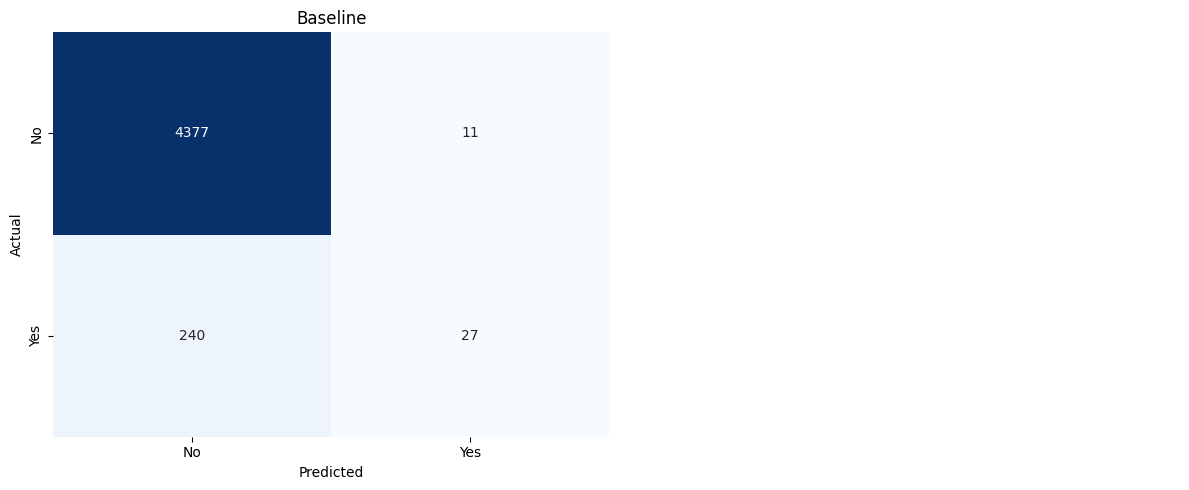

In [10]:
# ============================================================
# 4. MULTI-METHOD CONFUSION MATRIX COMPARISON
# ============================================================

def plot_confusion_matrices_grid(methods, dataset, model, save_path=None):
    """
    Plot confusion matrices for multiple methods in a grid.
    """
    n_methods = len(methods)
    cols = 2
    rows = (n_methods + 1) // 2
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 5*rows))
    
    # ALWAYS flatten, handle edge cases ← USE THIS
    if rows * cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, method in enumerate(methods):
        preds = load_predictions(method, dataset, model)
        cm = confusion_matrix(preds['y_true'], preds['y_pred'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No', 'Yes'],
                   yticklabels=['No', 'Yes'],
                   ax=axes[idx], cbar=False)
        
        axes[idx].set_title(f'{method.replace("_", " ").title()}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
    
    # Hide unused subplots
    for idx in range(n_methods, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Usage
# methods = ['baseline', 'correlation', 'l1_lasso', 'shap']
methods = ['baseline']
save_path = Path(COMPARISONS_DIR / "plots" / "cm_grid_rf.png")
save_path.parent.mkdir(parents=True, exist_ok=True)
plot_confusion_matrices_grid(methods, 'ibtracs.last3years', 'random_forest', save_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/anitarazafi/Desktop/masters/code/feature-selection/results/comparisons/predictions/correlation/ibtracs.last3years/logistic_regression_predictions.json'